In [1]:
from skimage.transform import resize
import numpy as np
import random
from skimage.filters import gaussian
from tqdm import tqdm
import matplotlib.cm as cm


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, ):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap_back =  heatmap
    heatmap = tf.maximum(heatmap, 0)
    cam_max = tf.math.reduce_max(heatmap)
    
    if cam_max != 0:
        heatmap = heatmap / cam_max
        
    if(np.percentile(heatmap, 99) == np.min(heatmap)):
        heatmap = (heatmap_back - np.min(heatmap_back)) / (np.max(heatmap_back) - np.min(heatmap_back))

    
    return heatmap.numpy()

In [2]:
#Importing Necessary Libraries.

from PIL import Image
import numpy as np
import pandas as pd 
import os
import re
import cv2
from pathlib import Path

import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import lime
from lime import lime_image
from matplotlib import pylab as P

import saliency.core as saliency
import glob2

from datetime import datetime, timedelta
from RISE_tf.explain_image import RISE


tf.__version__

'2.5.0'

In [3]:
INPUT_DIR = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/0DATASETS/EVAL_TESTE/OCT/"
OUTPUT_DIR = "./OUT/VGG-OCT-TRUE/"
MODEL = "/home/maia/Documents/Universidade/Universidade/UNIVERSIDADE/EXPERIMENTO/1TRAIN_NEW_VGG_CUSTOM/VGG_NET/OCT/VGG-OCT-TRUE/finetuned_model.h5"
INPUT_FILES = glob2.glob(os.path.join(INPUT_DIR, "*/*.jpeg"))
EVAL_SIZE = len(INPUT_FILES)

In [4]:
def image_generator(directory, res, batch_size=1):
    test_datagen = ImageDataGenerator()
    image_generator = test_datagen.flow_from_directory(
            directory,
            target_size=(res, res),
            color_mode= 'rgb',
            batch_size= batch_size,  
            class_mode= 'categorical',
            shuffle= False, 
            seed= 1337)
    return image_generator

In [5]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        if expected_keys==[saliency.base.INPUT_OUTPUT_GRADIENTS]:
            tape.watch(images)
            _, output_layer = model(images)
            output_layer = output_layer[:,target_class_idx]
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
        else:
            conv_layer, output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, conv_layer))
            return {saliency.base.CONVOLUTION_LAYER_VALUES: conv_layer,
                    saliency.base.CONVOLUTION_OUTPUT_GRADIENTS: gradients}

In [6]:
def save_greyscale(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file),  cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB))

def save_rgb(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    cv2.imwrite(str(Path(out_dir) / out_file), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
def save_heat(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    plt.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin = 0, vmax = 255)
    
def save_heat_image(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray')
    
def save_lime(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap='gray', vmin= mask.min(), vmax=mask.max())
    
def save_blur(out_dir, out_file, mask):
    Path.mkdir(Path(out_dir), parents=True, exist_ok=True)
    P.imsave(str(Path(out_dir) / out_file), arr = mask, cmap=P.cm.gray, vmin=0, vmax=1)
    
from matplotlib import pylab as P
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, file,  title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap=P.cm.gray, vmin=0, vmax=1)

def ShowHeatMap(im, file, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imsave(file, im, cmap='grey')
    
def abs_grayscale_norm(img):
    """Returns absolute value normalized image 2D."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        img = np.absolute(img)
        img = img/float(img.max())
    else:
        img = saliency.VisualizeImageGrayscale(img)
    return img

def diverging_norm(img):
    """Returns image with positive and negative values."""
    assert isinstance(img, np.ndarray), "img should be a numpy array"
    shp = img.shape
    if len(shp)< 2:
        raise ValueError("Array should have 2 or 3 dims!")
    if len(shp)==2:
        imgmax = np.absolute(img).max()
        img = img/float(imgmax)
    else:
        img = saliency.VisualizeImageDiverging(img)
    return img

def plot_single_img(img, ax=False, norm=diverging_norm, show_axis=False, grayscale=False, cmap='gray', title='', fig_size=(4,4)):
    plt.figure(figsize=fig_size)
    if norm:
        img = norm(img)
    if not show_axis:
        plt.axis('off')
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    
def normalize_image(x):
    x = np.array(x).astype(np.float32)
    x_min = x.min()
    x_max = x.max()
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [7]:
conv_layer_str = "block5_conv3"

model_path = MODEL
m = tf.keras.models.load_model(model_path)
m.summary()
conv_layer = m.get_layer(conv_layer_str)
model = tf.keras.models.Model([m.inputs], [conv_layer.output, m.output])   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

Found 100 images belonging to 4 classes.
1/1 [==============================] - 4s 4s/step - loss: 0.0139 - accuracy: 1.0000
Test Loss:  0.013851824216544628
Test Accuracy:  1.0


<ipython-input-6-538294728fb7>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=fig_size)


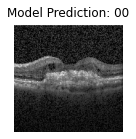

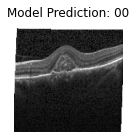

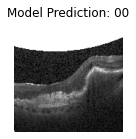

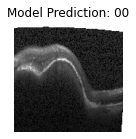

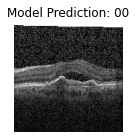

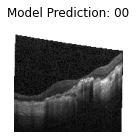

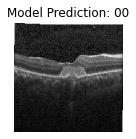

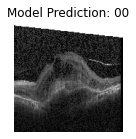

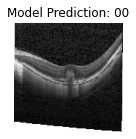

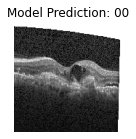

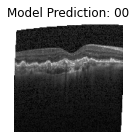

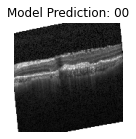

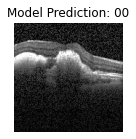

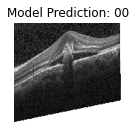

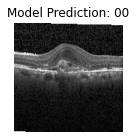

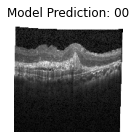

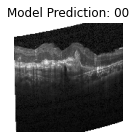

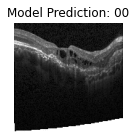

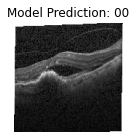

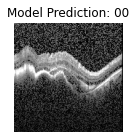

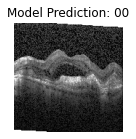

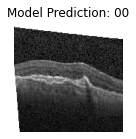

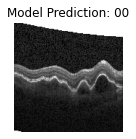

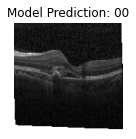

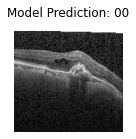

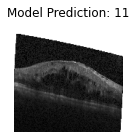

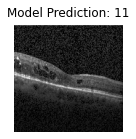

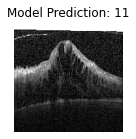

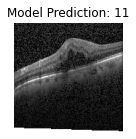

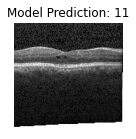

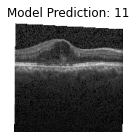

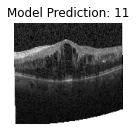

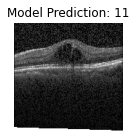

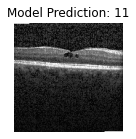

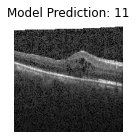

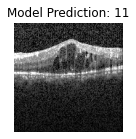

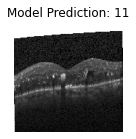

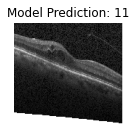

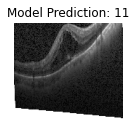

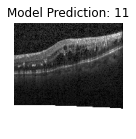

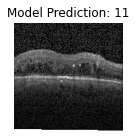

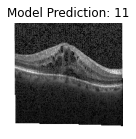

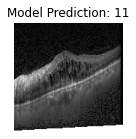

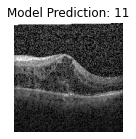

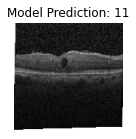

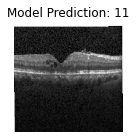

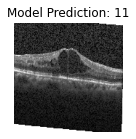

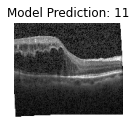

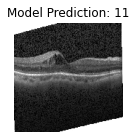

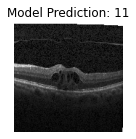

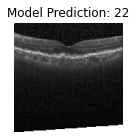

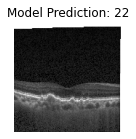

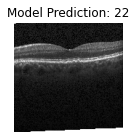

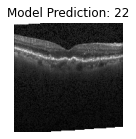

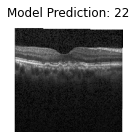

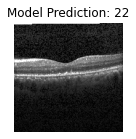

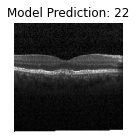

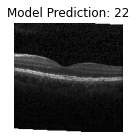

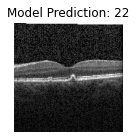

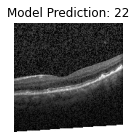

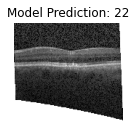

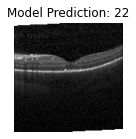

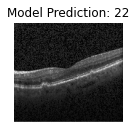

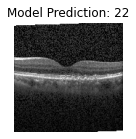

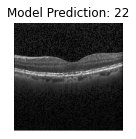

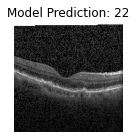

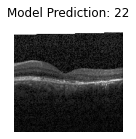

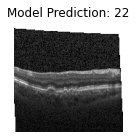

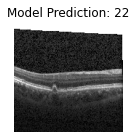

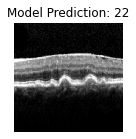

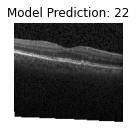

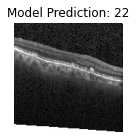

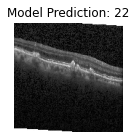

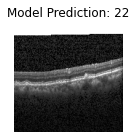

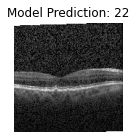

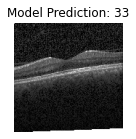

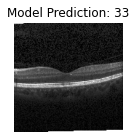

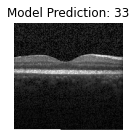

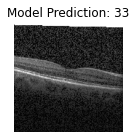

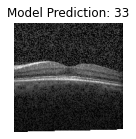

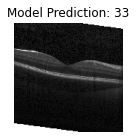

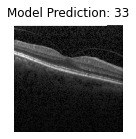

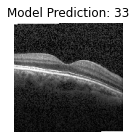

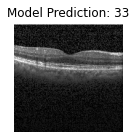

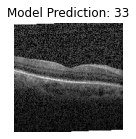

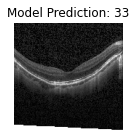

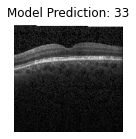

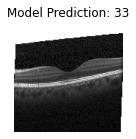

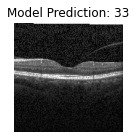

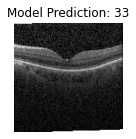

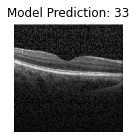

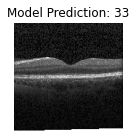

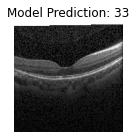

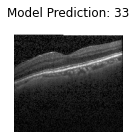

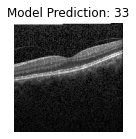

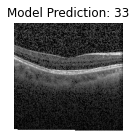

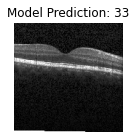

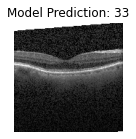

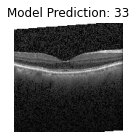

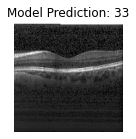

In [8]:
generator = image_generator(INPUT_DIR, 150, batch_size=EVAL_SIZE)
X, Y = generator.next()
logits = m.predict(X[:EVAL_SIZE])
predictions = logits.argmax(axis=1)

(eval_loss, eval_accuracy) = m.evaluate(generator, batch_size=EVAL_SIZE, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

for i in range(EVAL_SIZE):
    plot_single_img(X[i],
                    fig_size=(2,2),
                    title="Model Prediction: "+str(predictions[i]) +str(generator.classes[i]))

In [9]:
def vanilla_gradient(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    gradient_saliency = saliency.GradientSaliency()
    vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Vanilla Elapsed time:', timedelta(seconds=elapsed_seconds))
    return gradient_saliency, vanilla_mask_3d

def smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency):
    start_time = datetime.now()
    
    smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args, stdev_spread=0.15,nsamples=50,magnitude=False)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_mask_3d

def integrated_gradients_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    integrated_gradients = saliency.IntegratedGradients()
    baseline = np.zeros(im.shape)
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
      im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('IG Elapsed time:', timedelta(seconds=elapsed_seconds))
    return integrated_gradients, vanilla_integrated_gradients_mask_3d

def guided_IGS_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    guided_ig = saliency.GuidedIG()
    baselineGuided = np.zeros(im.shape)
    guided_ig_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baselineGuided, max_dist=1.0, fraction=0.5)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Guided Elapsed time:', timedelta(seconds=elapsed_seconds))
    return guided_ig_mask_3d

def blur_IG_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    
    blur_ig = saliency.BlurIG()
    blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Blur Elapsed time:', timedelta(seconds=elapsed_seconds))
    return blur_ig_mask_3d

def smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients):
    start_time = datetime.now()
    
    baseline = np.zeros(im.shape)
    smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=50, x_baseline=baseline, batch_size=20)

    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Smooth Elapsed time:', timedelta(seconds=elapsed_seconds))
    return smoothgrad_integrated_gradients_mask_3d

def grad_cam_func(img, m, conv_layer, prediction_class):
    start_time = datetime.now()
    gradcam = make_gradcam_heatmap(np.array([img]), m, conv_layer, pred_index=prediction_class)
    heatmap = np.uint8(255 * gradcam)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Grad Cam Elapsed time:', timedelta(seconds=elapsed_seconds))
    return jet_heatmap

def RISE_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = RISE()
    heatmaps, masks = explainer.explain(im, m)
    heatmap = heatmaps[prediction_class]
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('Rise Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

def XRAI_func(im, call_model_function, call_model_args):
    start_time = datetime.now()
    xrai_object = saliency.XRAI()
    xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('XRAI Elapsed time:', timedelta(seconds=elapsed_seconds))
    return xrai_attributions

def LIME_func(im, m, prediction_class):
    start_time = datetime.now()
    explainer = lime_image.LimeImageExplainer(verbose=True)
    explanation = explainer.explain_instance(im.astype('double'), m.predict, top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(prediction_class, positive_only=False, num_features=5, hide_rest=True)
    dict_heatmap = dict(explanation.local_exp[prediction_class])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    end_time = datetime.now()
    elapsed_seconds = int((end_time - start_time).total_seconds())
    print('LIME Elapsed time:', timedelta(seconds=elapsed_seconds))
    return heatmap

In [10]:
def return_mask_dicts(im, im_org, call_model_function, call_model_args, prediction_class, m):

    output_masks_dict = {}
    
    #Original
    #output_masks_dict["Original"] = im_org

    # Vanilla Gradient mask.
    #gradient_saliency, vanilla_mask_3d = vanilla_gradient(im, call_model_function, call_model_args)
    #output_masks_dict["Gradient"] = vanilla_mask_3d
    
    # Smooth Gradient mask.
    #output_masks_dict["SmoothGrad"] = smooth_vanilla_gradient(im, call_model_function, call_model_args, gradient_saliency) 

    # Smooth Input-Grad.
    #output_masks_dict["Input-Grad"] = np.multiply(vanilla_mask_3d, im)

    #IntegratedGradients
    #integrated_gradients, vanilla_integrated_gradients_mask_3d = integrated_gradients_func(im, call_model_function, call_model_args)
    #output_masks_dict["IntegratedGradients"] = vanilla_integrated_gradients_mask_3d

    # Compute the Guided IG mask.
    #output_masks_dict["GuidedIG"] = guided_IGS_func(im, call_model_function, call_model_args)

    # Compute the vanilla mask and the Blur IG mask.
    #output_masks_dict["BlurIG"] = blur_IG_func(im, call_model_function, call_model_args)

    # Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
    #output_masks_dict["IGSmoothGrad"] = smooth_grad_func(im, call_model_function, call_model_args, integrated_gradients)

    #GradCAM
    output_masks_dict["GradCam"] = grad_cam_func(im, m, conv_layer_str, prediction_class)

    #RISE
    #output_masks_dict["RISE"] = RISE_func(im, m, prediction_class)

    # Compute XRAI attributions with default parameters
    #output_masks_dict["XRAI"] = XRAI_func(im, call_model_function, call_model_args)

    #LIME
    #output_masks_dict["LIME"] = LIME_func(im, m, prediction_class)

    return output_masks_dict

In [11]:
results = []
logits = predictions
for i in range(EVAL_SIZE):
    call_model_args = {class_idx_str: logits[i]}
    nome = generator.filenames[i]
    results = return_mask_dicts(X[i], X[i], call_model_function, call_model_args, logits[i], m)
    for k, v in results.items():
        if(k == "Original"):
            mask_abs_norm = v
            mask_no_abs_norm = v
            mask_0_1_norm = v
        mask_abs_norm = abs_grayscale_norm(v)
        mask_no_abs_norm = diverging_norm(v)
        mask_0_1_norm = normalize_image(v)
        
        path= nome.split("/")[1].split(".")[0]+".png"
        save_lime(Path(OUTPUT_DIR+k), path, mask_abs_norm)

Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:22
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:25
Blur Elapsed time: 0:00:36
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:17
XRAI Elapsed time: 0:00:53


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3266708113271316
Prediction_local [-0.18429512]
Right: 3.522802e-18
Intercept 0.1613052688861345
Prediction_local [-0.05779748]
Right: 2.8177438e-11
Intercept 0.13255201441811254
Prediction_local [-0.0658646]
Right: 2.9976653e-11
Intercept 0.3794718979814201
Prediction_local [1.30795721]
Right: 1.0
LIME Elapsed time: 0:00:41
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:22
Blur Elapsed time: 0:00:37
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:17
XRAI Elapsed time: 0:00:52


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4718908566814814
Prediction_local [-0.0640194]
Right: 2.033321e-12
Intercept 0.06389057135290506
Prediction_local [0.05340558]
Right: 1.2095248e-07
Intercept 0.218568865245085
Prediction_local [0.02046086]
Right: 1.2408381e-07
Intercept 0.24564972740205998
Prediction_local [0.99015294]
Right: 0.99999976
LIME Elapsed time: 0:00:40
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:22
Blur Elapsed time: 0:00:35
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:20
XRAI Elapsed time: 0:00:51


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.0914257023630753
Prediction_local [-0.05545214]
Right: 2.1179601e-15
Intercept 0.31457774057044424
Prediction_local [-0.05206558]
Right: 1.3818169e-09
Intercept 0.062193265382437295
Prediction_local [-0.03696708]
Right: 4.8050555e-07
Intercept 0.5318032755969819
Prediction_local [1.14448481]
Right: 0.9999995
LIME Elapsed time: 0:00:40
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:35
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:21
XRAI Elapsed time: 0:00:51


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.28452405567469397
Prediction_local [-0.1587172]
Right: 3.6846308e-09
Intercept 0.07823903363226543
Prediction_local [-0.04650911]
Right: 8.100833e-08
Intercept 0.0894559280563264
Prediction_local [-0.00427238]
Right: 1.6598498e-05
Intercept 0.5477809742752012
Prediction_local [1.20949869]
Right: 0.9999833
LIME Elapsed time: 0:00:41
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:33
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:24
XRAI Elapsed time: 0:00:50


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4909957019525278
Prediction_local [-0.19365]
Right: 3.3574622e-15
Intercept 0.1634444940405209
Prediction_local [-0.01962525]
Right: 7.623657e-14
Intercept 0.2201023593316742
Prediction_local [-0.03191326]
Right: 3.5273654e-08
Intercept 0.12545743823465172
Prediction_local [1.24518852]
Right: 1.0
LIME Elapsed time: 0:00:43
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:33
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:24
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.05883499156832272
Prediction_local [-0.03535378]
Right: 6.9013983e-12
Intercept 0.034317120924529126
Prediction_local [-0.01979692]
Right: 2.9554713e-11
Intercept 0.12813608666064522
Prediction_local [-0.03301096]
Right: 7.019821e-08
Intercept 0.7787118060777574
Prediction_local [1.08816166]
Right: 0.9999999
LIME Elapsed time: 0:00:44
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:33
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:24
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3928787488404101
Prediction_local [-0.16963175]
Right: 2.4231648e-14
Intercept 0.12674488380418414
Prediction_local [-0.01841277]
Right: 2.1081184e-11
Intercept 0.1956482419091668
Prediction_local [-0.01324159]
Right: 6.3296625e-07
Intercept 0.28472810907566265
Prediction_local [1.20128613]
Right: 0.9999994
LIME Elapsed time: 0:00:44
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:34
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:22
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.21440829658999264
Prediction_local [-0.10141523]
Right: 3.233204e-11
Intercept 0.09484786068732651
Prediction_local [-0.0361864]
Right: 1.4262942e-08
Intercept 0.13010682568133008
Prediction_local [-0.04180066]
Right: 1.6143916e-06
Intercept 0.5606370268840599
Prediction_local [1.17940229]
Right: 0.99999833
LIME Elapsed time: 0:00:44
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:30
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:27
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.23163349681248008
Prediction_local [-0.09632448]
Right: 1.1321963e-06
Intercept 0.05135273792213561
Prediction_local [0.06440282]
Right: 4.167466e-05
Intercept 0.17734233046178455
Prediction_local [0.05275693]
Right: 0.0023482274
Intercept 0.5396714611472596
Prediction_local [0.97916471]
Right: 0.9976089
LIME Elapsed time: 0:00:44
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:31
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:26
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.18254420390599352
Prediction_local [-0.09170376]
Right: 1.4148114e-15
Intercept 0.08071339715762658
Prediction_local [-0.04078196]
Right: 2.7366578e-10
Intercept 0.10625434799636962
Prediction_local [-0.04033509]
Right: 3.7035808e-10
Intercept 0.6304880424405546
Prediction_local [1.17282082]
Right: 1.0
LIME Elapsed time: 0:00:45
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:30
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:28
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.24087204007357754
Prediction_local [-0.14160055]
Right: 7.061816e-11
Intercept 0.123673730707723
Prediction_local [-0.04483999]
Right: 1.06062544e-07
Intercept 0.16732390482593
Prediction_local [-0.08372001]
Right: 2.6093588e-07
Intercept 0.4681302979673859
Prediction_local [1.27016057]
Right: 0.99999964
LIME Elapsed time: 0:00:46
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:28
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.37858492183758147
Prediction_local [-0.11981554]
Right: 1.0196935e-08
Intercept 0.09597482086501345
Prediction_local [0.039558]
Right: 4.6058113e-07
Intercept 0.21171519556754848
Prediction_local [0.00688617]
Right: 1.5188166e-05
Intercept 0.3137250912208113
Prediction_local [1.07337134]
Right: 0.9999844
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:28
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:29
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.21190991768425213
Prediction_local [-0.13340241]
Right: 2.4840766e-14
Intercept 0.10020418107746826
Prediction_local [-0.04120365]
Right: 4.4452053e-13
Intercept 0.10103914003217114
Prediction_local [-0.04133364]
Right: 1.9863087e-06
Intercept 0.5868467458047322
Prediction_local [1.21593971]
Right: 0.999998
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3194317984817695
Prediction_local [-0.14389963]
Right: 6.019768e-13
Intercept 0.2719420909364239
Prediction_local [0.07961007]
Right: 2.2834534e-12
Intercept 0.1119419081178985
Prediction_local [-0.04921067]
Right: 1.5051913e-08
Intercept 0.2966842132727078
Prediction_local [1.11350023]
Right: 1.0
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.45177154474273357
Prediction_local [-0.1953935]
Right: 3.806681e-09
Intercept 0.18401338642756052
Prediction_local [-0.04041679]
Right: 5.113847e-06
Intercept 0.18198878370227234
Prediction_local [-0.03820291]
Right: 1.4971863e-05
Intercept 0.18222629274712698
Prediction_local [1.27401319]
Right: 0.99997985
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:28
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:30
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5963708904693658
Prediction_local [-0.1981218]
Right: 1.749011e-17
Intercept 0.2066619139245039
Prediction_local [-0.08164609]
Right: 1.1469206e-16
Intercept 0.12334648163097255
Prediction_local [0.05569823]
Right: 4.533774e-15
Intercept 0.07362072056471314
Prediction_local [1.22406966]
Right: 1.0
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:32
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12549171605115636
Prediction_local [-0.06815848]
Right: 7.221954e-18
Intercept 0.09203158443921862
Prediction_local [-0.04430694]
Right: 1.242798e-15
Intercept 0.07066815172412838
Prediction_local [-0.02079149]
Right: 3.5850606e-15
Intercept 0.7118085487144538
Prediction_local [1.13325691]
Right: 1.0
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.22529889603039377
Prediction_local [-0.11968847]
Right: 1.1982528e-08
Intercept 0.08704506122994529
Prediction_local [-0.04243109]
Right: 2.180953e-07
Intercept 0.09804926787513149
Prediction_local [0.02414449]
Right: 0.0009201683
Intercept 0.5896067576039732
Prediction_local [1.1379751]
Right: 0.9990796
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:32
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4319058744039841
Prediction_local [-0.11732289]
Right: 2.8748198e-11
Intercept 0.1802749505709179
Prediction_local [-0.02592051]
Right: 1.3329208e-07
Intercept 0.18668648958842501
Prediction_local [-0.06301153]
Right: 2.4531084e-07
Intercept 0.20113269299715364
Prediction_local [1.20625493]
Right: 0.99999964
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.26523061238367956
Prediction_local [-0.14207715]
Right: 3.1973596e-10
Intercept 0.11838034943739861
Prediction_local [-0.03013639]
Right: 4.748007e-09
Intercept 0.05498606010318799
Prediction_local [-0.0239676]
Right: 1.936038e-07
Intercept 0.561403003032047
Prediction_local [1.19618112]
Right: 0.99999976
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:27
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.11143734248749851
Prediction_local [-0.06886418]
Right: 2.8188644e-13
Intercept 0.053453343253639464
Prediction_local [-0.03042544]
Right: 1.0141493e-10
Intercept 0.06475113524300302
Prediction_local [-0.02298081]
Right: 1.4041264e-10
Intercept 0.7703581999521429
Prediction_local [1.12227041]
Right: 1.0
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:28
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.23697476950152807
Prediction_local [-0.12036101]
Right: 3.2713835e-11
Intercept 0.22174418720806904
Prediction_local [-0.04415362]
Right: 3.4945344e-10
Intercept 0.14899400184451922
Prediction_local [-0.05979156]
Right: 2.4255237e-07
Intercept 0.39228703209566956
Prediction_local [1.2243062]
Right: 0.99999976
LIME Elapsed time: 0:00:46
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.09218427082087807
Prediction_local [-0.04158205]
Right: 6.1137384e-09
Intercept 0.12593491923422057
Prediction_local [-0.06559973]
Right: 6.6669252e-09
Intercept 0.05075668481656112
Prediction_local [-0.0245263]
Right: 5.7415496e-06
Intercept 0.7311241022024031
Prediction_local [1.13170811]
Right: 0.9999943
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4404945125385935
Prediction_local [-0.08827129]
Right: 1.5010351e-06
Intercept 0.10989213299289272
Prediction_local [-0.00880324]
Right: 2.2112858e-05
Intercept 0.159595757021752
Prediction_local [0.0033743]
Right: 0.00028955872
Intercept 0.29001761128716597
Prediction_local [1.09370022]
Right: 0.9996867
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3143177116401885
Prediction_local [-0.16569041]
Right: 7.689648e-15
Intercept 0.12605616330970498
Prediction_local [-0.04358407]
Right: 1.4471135e-09
Intercept 0.10468487281990568
Prediction_local [0.0162498]
Right: 3.4361751e-09
Intercept 0.4549412545330307
Prediction_local [1.19302469]
Right: 1.0
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.09853080802093146
Prediction_local [-0.04530584]
Right: 1.1038069e-10
Intercept 0.368694952466726
Prediction_local [-0.15630432]
Right: 1.3789221e-08
Intercept 0.5968106623501082
Prediction_local [-0.25869514]
Right: 5.8311254e-08
Intercept -0.06403642968871637
Prediction_local [1.46030531]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.16639839244713014
Prediction_local [-0.07431381]
Right: 3.501034e-17
Intercept 1.057601316490981
Prediction_local [-0.23318805]
Right: 5.6114633e-15
Intercept 0.2298081113848265
Prediction_local [-0.10041474]
Right: 1.0972117e-10
Intercept -0.45380779647791747
Prediction_local [1.40791657]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.07371650270221937
Prediction_local [-0.03704784]
Right: 5.292274e-15
Intercept 0.26563909706346966
Prediction_local [-0.13232877]
Right: 3.641034e-13
Intercept 0.7169191876012719
Prediction_local [-0.17311372]
Right: 2.0972026e-07
Intercept -0.056274766438022206
Prediction_local [1.34249031]
Right: 0.99999976
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:16
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4909933071961067
Prediction_local [-0.12469447]
Right: 5.2776682e-11
Intercept 0.1848875894038265
Prediction_local [-0.03421411]
Right: 1.0923939e-10
Intercept 0.5922648392657138
Prediction_local [0.37870176]
Right: 2.2073787e-06
Intercept -0.2681457283917679
Prediction_local [0.78020681]
Right: 0.99999774
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2722635044236312
Prediction_local [0.03394207]
Right: 6.8465127e-09
Intercept 0.7045093699759776
Prediction_local [0.49729619]
Right: 9.224049e-07
Intercept 0.2418659430343641
Prediction_local [-0.02630423]
Right: 3.1129925e-06
Intercept -0.21863880533759766
Prediction_local [0.49506597]
Right: 0.99999595
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:16
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2494078570372158
Prediction_local [-0.09785769]
Right: 4.1929658e-11
Intercept 0.8722740652706681
Prediction_local [-0.17795743]
Right: 1.07531616e-10
Intercept 0.32048688408538567
Prediction_local [0.17845003]
Right: 6.470269e-07
Intercept -0.4421687975149304
Prediction_local [1.09736508]
Right: 0.9999994
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.16573708943164359
Prediction_local [-0.06997912]
Right: 1.1764381e-14
Intercept 0.4550763281294986
Prediction_local [-0.20549943]
Right: 9.377764e-13
Intercept 0.8184774789887748
Prediction_local [-0.29409204]
Right: 9.861208e-11
Intercept -0.4392908817953093
Prediction_local [1.56957057]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.26018596275400513
Prediction_local [-0.05897166]
Right: 2.3898982e-13
Intercept 0.8793643708491266
Prediction_local [-0.03731267]
Right: 2.6791603e-12
Intercept 0.4002376964408581
Prediction_local [0.0481832]
Right: 4.0793165e-07
Intercept -0.5397880625908091
Prediction_local [1.04810115]
Right: 0.99999964
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:35
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.21913739481809766
Prediction_local [0.02515936]
Right: 3.0756069e-06
Intercept 0.8587038304386565
Prediction_local [0.07503202]
Right: 1.1632285e-05
Intercept 0.1840246406372393
Prediction_local [-0.01032183]
Right: 0.000548969
Intercept -0.26186583783923184
Prediction_local [0.91013043]
Right: 0.9994362
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2158421316925284
Prediction_local [-0.05371277]
Right: 1.8737042e-13
Intercept 0.7985926305038513
Prediction_local [-0.00629572]
Right: 1.1601481e-12
Intercept 0.3645310466774748
Prediction_local [-0.03291168]
Right: 5.6775837e-09
Intercept -0.3789658075399872
Prediction_local [1.09292017]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1460932527698381
Prediction_local [-0.05866984]
Right: 2.9784588e-11
Intercept 0.661308161430975
Prediction_local [-0.29346578]
Right: 4.1072226e-10
Intercept 0.46150966443610963
Prediction_local [-0.02225096]
Right: 2.9337635e-08
Intercept -0.268911074183402
Prediction_local [1.37438658]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.08777251806272451
Prediction_local [-0.02803009]
Right: 5.028838e-10
Intercept 0.23596166129891077
Prediction_local [-0.09002742]
Right: 7.280085e-09
Intercept 0.8679405043226807
Prediction_local [0.15841203]
Right: 9.758457e-05
Intercept -0.1916746683227749
Prediction_local [0.95964546]
Right: 0.99990237
LIME Elapsed time: 0:00:52
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.16569015371621157
Prediction_local [-0.06965915]
Right: 7.134967e-10
Intercept 0.6282014331041373
Prediction_local [0.24495694]
Right: 3.6904098e-08
Intercept 0.34149827347063644
Prediction_local [-0.07962943]
Right: 2.5839147e-06
Intercept -0.135389857464698
Prediction_local [0.90433164]
Right: 0.9999974
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:35
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.10790904043782015
Prediction_local [-0.00258025]
Right: 3.1842558e-07
Intercept 0.4757116570111719
Prediction_local [-0.14959699]
Right: 4.5034975e-07
Intercept 0.5397175795071691
Prediction_local [-0.11640037]
Right: 9.082779e-05
Intercept -0.1233382697924793
Prediction_local [1.2685776]
Right: 0.9999083
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20309461436397686
Prediction_local [-0.0450778]
Right: 6.940889e-08
Intercept 0.303086948144596
Prediction_local [-0.03412221]
Right: 7.986937e-07
Intercept 0.7882059746264647
Prediction_local [-0.05076314]
Right: 0.00024829354
Intercept -0.29438753203558554
Prediction_local [1.12996314]
Right: 0.9997508
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20784123030534496
Prediction_local [-0.03384234]
Right: 4.0594435e-13
Intercept 0.6857544937797602
Prediction_local [-0.09485878]
Right: 1.6173297e-10
Intercept 0.5320681120886033
Prediction_local [0.20680926]
Right: 2.7506486e-08
Intercept -0.42566383730911095
Prediction_local [0.92189185]
Right: 1.0
LIME Elapsed time: 0:00:52
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:16
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6153964678182584
Prediction_local [-0.27597767]
Right: 4.0873372e-12
Intercept 0.23015045597252465
Prediction_local [-0.10839581]
Right: 6.330773e-12
Intercept 0.48719694297788807
Prediction_local [-0.20201094]
Right: 3.5118312e-08
Intercept -0.33274386237150233
Prediction_local [1.58638442]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.09286875118598636
Prediction_local [-0.03621866]
Right: 8.734887e-11
Intercept 0.3983388243714039
Prediction_local [-0.08592969]
Right: 1.3831161e-09
Intercept 0.7431505495725651
Prediction_local [-0.18745025]
Right: 1.0475311e-06
Intercept -0.23435811539975693
Prediction_local [1.30959859]
Right: 0.9999989
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5372614781780544
Prediction_local [-0.100677]
Right: 2.0761498e-05
Intercept 0.20938888723647958
Prediction_local [0.01740476]
Right: 0.002361539
Intercept 0.4324741239001317
Prediction_local [0.08924419]
Right: 0.04694969
Intercept -0.17912449524325164
Prediction_local [0.99402806]
Right: 0.95066804
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20099291526354282
Prediction_local [-0.04988434]
Right: 6.1550702e-09
Intercept 0.9128981892724193
Prediction_local [-0.09489441]
Right: 3.639284e-08
Intercept 0.24590295484794808
Prediction_local [-0.03064361]
Right: 6.642065e-06
Intercept -0.3597940537162338
Prediction_local [1.17542235]
Right: 0.9999933
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2643388955914605
Prediction_local [-0.08816066]
Right: 3.1700897e-09
Intercept 0.7812048496286146
Prediction_local [0.20588596]
Right: 1.2005488e-08
Intercept 0.3339525281857965
Prediction_local [-0.09743927]
Right: 2.0980127e-07
Intercept -0.37949625833475087
Prediction_local [0.97971396]
Right: 0.99999976
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.21147864126264923
Prediction_local [-0.09609042]
Right: 2.3967714e-15
Intercept 0.6384185114905517
Prediction_local [-0.1316354]
Right: 3.8243087e-14
Intercept 0.5755003543110542
Prediction_local [-0.26317337]
Right: 1.5854238e-11
Intercept -0.4253975089127233
Prediction_local [1.4908992]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2097897137174058
Prediction_local [-0.07393744]
Right: 3.0343716e-09
Intercept 0.49481829270037603
Prediction_local [-0.14458843]
Right: 2.823065e-08
Intercept 0.6176582187557677
Prediction_local [0.02149345]
Right: 5.0071653e-06
Intercept -0.32226622410236866
Prediction_local [1.19703241]
Right: 0.999995
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.22657630574144105
Prediction_local [-0.06930724]
Right: 4.1784074e-14
Intercept 0.9608202925322906
Prediction_local [-0.07265641]
Right: 9.593873e-13
Intercept 0.39063960596103176
Prediction_local [-0.11389826]
Right: 4.6570033e-11
Intercept -0.578036208002273
Prediction_local [1.25586191]
Right: 1.0
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:35
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.24087343338856626
Prediction_local [-0.10350877]
Right: 1.2834148e-09
Intercept 0.5507033231114506
Prediction_local [-0.20767732]
Right: 5.310351e-09
Intercept 0.4779497505458479
Prediction_local [-0.17270702]
Right: 4.8878643e-08
Intercept -0.2695265313422085
Prediction_local [1.48389314]
Right: 1.0
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.16129235607325937
Prediction_local [-0.03027927]
Right: 1.6446464e-06
Intercept 0.7516313090498262
Prediction_local [-0.24235208]
Right: 4.9772557e-06
Intercept 0.17471017960504515
Prediction_local [0.55687523]
Right: 0.0047349064
Intercept -0.08763384463173746
Prediction_local [0.71575613]
Right: 0.9952585
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:22
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.23005582300963745
Prediction_local [-0.01538611]
Right: 8.881648e-09
Intercept 0.4180983093804606
Prediction_local [-0.1340773]
Right: 1.885607e-08
Intercept 0.4371488745954541
Prediction_local [0.75333074]
Right: 0.032571815
Intercept -0.08530302027894168
Prediction_local [0.39613269]
Right: 0.96742815
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12027758794349239
Prediction_local [-0.0351697]
Right: 1.08648465e-10
Intercept 0.7815662169555857
Prediction_local [0.60238183]
Right: 9.2664656e-08
Intercept 0.23150950452518548
Prediction_local [-0.11248955]
Right: 1.8335385e-06
Intercept -0.1333532920944679
Prediction_local [0.54527742]
Right: 0.9999981
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.7902766665373318
Prediction_local [-0.08528091]
Right: 5.2320775e-06
Intercept 0.13312364298572832
Prediction_local [-0.0148219]
Right: 3.3424498e-05
Intercept 0.1576021132026621
Prediction_local [0.50568909]
Right: 0.04647372
Intercept -0.08100244958800396
Prediction_local [0.59441375]
Right: 0.95348763
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.6676093395299382
Prediction_local [-0.05740529]
Right: 5.6578347e-06
Intercept 0.12644852891705397
Prediction_local [0.03268851]
Right: 4.4344586e-05
Intercept 0.15571226928834386
Prediction_local [0.67765591]
Right: 0.27090055
Intercept 0.050229864895937754
Prediction_local [0.34706086]
Right: 0.72904944
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.07586029784430896
Prediction_local [0.24114406]
Right: 9.1549286e-05
Intercept 0.18743819718510152
Prediction_local [-0.06452088]
Right: 0.00051271275
Intercept 0.7343475817424505
Prediction_local [0.58220496]
Right: 0.0024481628
Intercept 0.0023539306186927955
Prediction_local [0.24117186]
Right: 0.9969476
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.10768200894594938
Prediction_local [0.0105733]
Right: 1.4195908e-07
Intercept 0.2008793746759686
Prediction_local [0.00435979]
Right: 2.1857017e-05
Intercept 0.8445180668178011
Prediction_local [0.34900016]
Right: 0.00021647097
Intercept -0.15307944034851756
Prediction_local [0.63606674]
Right: 0.9997615
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12491032282286471
Prediction_local [-0.0404819]
Right: 2.4121834e-06
Intercept 0.15808756167655125
Prediction_local [-0.0527116]
Right: 5.8935e-05
Intercept 0.9324831110950167
Prediction_local [0.3176433]
Right: 0.006977419
Intercept -0.2154810068090121
Prediction_local [0.77555022]
Right: 0.9929612
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:35
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.16581437188591203
Prediction_local [-0.02543754]
Right: 6.2367564e-14
Intercept 0.9076918469646313
Prediction_local [0.0659859]
Right: 5.4239117e-11
Intercept 0.2628688360431174
Prediction_local [-0.09172864]
Right: 3.602337e-06
Intercept -0.3363750460795625
Prediction_local [1.05118026]
Right: 0.9999964
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.10509343978021397
Prediction_local [-0.02209808]
Right: 1.9177109e-05
Intercept 0.6679821787789739
Prediction_local [0.56024528]
Right: 0.00013787177
Intercept 0.3428085586663128
Prediction_local [-0.12554953]
Right: 0.0049584135
Intercept -0.1158841766386654
Prediction_local [0.58740233]
Right: 0.99488455
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:35
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.07115146341096705
Prediction_local [0.04473033]
Right: 0.0010218084
Intercept 0.29040336043866977
Prediction_local [-0.01603859]
Right: 0.012232338
Intercept 0.5576218155725909
Prediction_local [0.54877234]
Right: 0.036557518
Intercept 0.08082335464478035
Prediction_local [0.42253593]
Right: 0.9501884
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:16
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept -0.027567071778346358
Prediction_local [0.39936904]
Right: 0.0060696253
Intercept 0.8941860230270589
Prediction_local [0.22140893]
Right: 0.0072191814
Intercept 0.17889412398097573
Prediction_local [0.04359864]
Right: 0.016732406
Intercept -0.045513089278697655
Prediction_local [0.3356234]
Right: 0.96997887
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1086697012537358
Prediction_local [-0.02741839]
Right: 1.7952629e-11
Intercept 0.5076954987754697
Prediction_local [0.04380197]
Right: 2.5620954e-09
Intercept 0.3369163186196048
Prediction_local [-0.08150851]
Right: 1.3573723e-05
Intercept 0.04671850568800329
Prediction_local [1.0651249]
Right: 0.9999864
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:12
Guided Elapsed time: 0:00:16
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.11342814085001965
Prediction_local [0.00657755]
Right: 9.40657e-10
Intercept 0.8467528144643022
Prediction_local [0.27712541]
Right: 1.5768562e-08
Intercept 0.36162427476117665
Prediction_local [-0.06722331]
Right: 6.830735e-05
Intercept -0.32180522811932866
Prediction_local [0.78352036]
Right: 0.9999317
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.14409921374509277
Prediction_local [-0.03829424]
Right: 3.610987e-05
Intercept 0.3503290110004327
Prediction_local [0.03546465]
Right: 0.00013957122
Intercept 0.6248599111245917
Prediction_local [0.38379019]
Right: 0.009112221
Intercept -0.11928812746795514
Prediction_local [0.61903939]
Right: 0.9907121
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:23
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:36
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1625893822325192
Prediction_local [-0.01695644]
Right: 4.4815932e-10
Intercept 0.7418008074593434
Prediction_local [-0.09292688]
Right: 2.604069e-09
Intercept 0.33068554955372786
Prediction_local [0.03231521]
Right: 0.0005273364
Intercept -0.23507573691575956
Prediction_local [1.0775681]
Right: 0.9994727
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:17
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:16
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:37
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1603868393631379
Prediction_local [0.0295176]
Right: 0.0034009668
Intercept 0.2760556357877758
Prediction_local [0.16641751]
Right: 0.03120684
Intercept 0.5893473356275655
Prediction_local [0.50385641]
Right: 0.10854846
Intercept -0.025789799844506023
Prediction_local [0.30020846]
Right: 0.8568437
LIME Elapsed time: 0:00:51
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:35
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5036660943073337
Prediction_local [-0.11191249]
Right: 8.698583e-05
Intercept 0.19805177580476746
Prediction_local [0.00937119]
Right: 9.5601776e-05
Intercept 0.3730006829054313
Prediction_local [0.51975327]
Right: 0.035164144
Intercept -0.07471857497241335
Prediction_local [0.58278804]
Right: 0.9646533
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1985961306338837
Prediction_local [0.05307503]
Right: 1.1677054e-07
Intercept 0.5244819347840601
Prediction_local [-0.029297]
Right: 6.795688e-07
Intercept 0.4884844336953094
Prediction_local [-0.01898366]
Right: 0.0017031888
Intercept -0.21156248675863415
Prediction_local [0.99520563]
Right: 0.99829596
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.15359630396653753
Prediction_local [-0.05904096]
Right: 1.2462603e-08
Intercept 0.28721559500323857
Prediction_local [-0.12619792]
Right: 5.65073e-07
Intercept 0.8277465190659326
Prediction_local [0.58357354]
Right: 0.0002725944
Intercept -0.2685584247802384
Prediction_local [0.60166534]
Right: 0.99972683
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1617382777003358
Prediction_local [-0.00510851]
Right: 9.8484584e-08
Intercept 0.6836404695730443
Prediction_local [0.25820607]
Right: 2.515872e-06
Intercept 0.30122395302586413
Prediction_local [-0.04007991]
Right: 0.00019978576
Intercept -0.1466027117530308
Prediction_local [0.78698235]
Right: 0.99979764
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5660476203634864
Prediction_local [0.04731697]
Right: 8.03175e-09
Intercept 0.13843022187213022
Prediction_local [-0.01471055]
Right: 3.240199e-08
Intercept 0.5092876033207514
Prediction_local [0.13139719]
Right: 0.00071827305
Intercept -0.21376544721253138
Prediction_local [0.8359964]
Right: 0.9992817
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.5329817439347045
Prediction_local [-0.0377947]
Right: 5.09689e-09
Intercept 0.12330750478572641
Prediction_local [0.01796762]
Right: 2.0019732e-08
Intercept 0.46934330633512944
Prediction_local [0.08884674]
Right: 0.0035588362
Intercept -0.12563254039214494
Prediction_local [0.93098033]
Right: 0.9964412
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12056345149842565
Prediction_local [0.10091496]
Right: 8.617657e-09
Intercept 0.6865116486309788
Prediction_local [0.15582925]
Right: 1.7861089e-08
Intercept 0.3153980546367159
Prediction_local [-0.05409387]
Right: 0.0004866317
Intercept -0.12247316245248652
Prediction_local [0.79734967]
Right: 0.9995134
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.1791078449450602
Prediction_local [-0.02299072]
Right: 1.2286927e-09
Intercept 0.8794844017818262
Prediction_local [0.12802536]
Right: 5.15324e-07
Intercept 0.2862644637318719
Prediction_local [-0.05471767]
Right: 7.393035e-06
Intercept -0.3448567157037511
Prediction_local [0.94968303]
Right: 0.99999213
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.24719388178008012
Prediction_local [-0.0618867]
Right: 0.0007112985
Intercept 0.10306239959347895
Prediction_local [-0.00957905]
Right: 0.0031882583
Intercept 0.23071569748677764
Prediction_local [0.01873934]
Right: 0.013728308
Intercept 0.4190280240530944
Prediction_local [1.05272641]
Right: 0.9823721
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:17
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:46


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3513104592395846
Prediction_local [-0.14106057]
Right: 0.000104266255
Intercept 0.10732477238059854
Prediction_local [-0.0250487]
Right: 0.0006186589
Intercept 0.14500490421342715
Prediction_local [0.36945235]
Right: 0.018165028
Intercept 0.39635986135823165
Prediction_local [0.79665692]
Right: 0.98111206
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.19516647695364003
Prediction_local [-0.07151615]
Right: 0.0009604323
Intercept 0.08809879044627067
Prediction_local [-0.00214754]
Right: 0.005289148
Intercept 0.16557401770279084
Prediction_local [0.02244659]
Right: 0.020115055
Intercept 0.5511607159756768
Prediction_local [1.0512171]
Right: 0.9736354
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20301506361449534
Prediction_local [-0.0583911]
Right: 0.003089624
Intercept 0.12894062494945246
Prediction_local [-0.00676388]
Right: 0.020498278
Intercept 0.14464871952986416
Prediction_local [0.06965649]
Right: 0.036166243
Intercept 0.5233955877344114
Prediction_local [0.9954985]
Right: 0.9402458
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20079323524035064
Prediction_local [-0.06855419]
Right: 0.00039416394
Intercept 0.06437879599708421
Prediction_local [-0.01309527]
Right: 0.0005870198
Intercept 0.2015736603715823
Prediction_local [-0.0120027]
Right: 0.0114921285
Intercept 0.533254300853401
Prediction_local [1.09365217]
Right: 0.9875267
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:24
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.14488209892892637
Prediction_local [-0.05284025]
Right: 0.0004818967
Intercept 0.11307817778282636
Prediction_local [0.03606667]
Right: 0.0042697676
Intercept 0.1925345913370679
Prediction_local [0.01235681]
Right: 0.01107307
Intercept 0.5495051569398632
Prediction_local [1.00441674]
Right: 0.98417526
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:25
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:34
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.13392463036110852
Prediction_local [-0.06448279]
Right: 7.747094e-05
Intercept 0.12719141531357864
Prediction_local [-0.02513344]
Right: 0.0023436963
Intercept 0.10310017545560501
Prediction_local [0.05542745]
Right: 0.0028075315
Intercept 0.6357837930536626
Prediction_local [1.03418875]
Right: 0.9947713
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:21
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:28
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:30
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2789814176195911
Prediction_local [-0.12633919]
Right: 0.0011238969
Intercept 0.1331436446459102
Prediction_local [0.00176852]
Right: 0.0064695976
Intercept 0.1396691420385583
Prediction_local [-0.02417453]
Right: 0.018083205
Intercept 0.4482057877707604
Prediction_local [1.14874521]
Right: 0.97432333
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:28
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.20395065169999216
Prediction_local [-0.08828534]
Right: 0.00028312713
Intercept 0.14977291999920359
Prediction_local [0.02729913]
Right: 0.003008498
Intercept 0.12064642077871857
Prediction_local [0.10098622]
Right: 0.12759648
Intercept 0.5256299970320549
Prediction_local [0.96]
Right: 0.8691119
LIME Elapsed time: 0:00:46
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:28
XRAI Elapsed time: 0:00:50


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.19441533148972515
Prediction_local [-0.0052341]
Right: 0.0059692287
Intercept 0.06409495219880587
Prediction_local [0.06722954]
Right: 0.03584652
Intercept 0.10090377193931135
Prediction_local [0.11609917]
Right: 0.074395366
Intercept 0.6405859471622702
Prediction_local [0.82190539]
Right: 0.88378894
LIME Elapsed time: 0:00:45
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:28
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.4995225487095752
Prediction_local [-0.16173285]
Right: 0.00048735176
Intercept 0.07766668539780476
Prediction_local [-0.03167273]
Right: 0.0005588003
Intercept 0.13169718813323095
Prediction_local [0.30555757]
Right: 0.07679168
Intercept 0.2911135823226665
Prediction_local [0.887848]
Right: 0.9221622
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.19399195106447925
Prediction_local [-0.00066938]
Right: 0.00090775173
Intercept 0.17906546842046936
Prediction_local [0.07062462]
Right: 0.009613144
Intercept 0.0868999498387128
Prediction_local [0.04865073]
Right: 0.010445967
Intercept 0.5400426497969288
Prediction_local [0.88139401]
Right: 0.97903305
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.24429628928279407
Prediction_local [-0.10360397]
Right: 1.777482e-05
Intercept 0.1739025683568176
Prediction_local [0.05591621]
Right: 0.0009851498
Intercept 0.1710731581016921
Prediction_local [-0.03882658]
Right: 0.001448635
Intercept 0.41072797934328187
Prediction_local [1.08651434]
Right: 0.9975484
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:32
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.15058592182874986
Prediction_local [-0.02055429]
Right: 0.00015421279
Intercept 0.1741355559089109
Prediction_local [0.03269994]
Right: 0.0038267989
Intercept 0.14027797151376337
Prediction_local [0.04989001]
Right: 0.007508453
Intercept 0.5350005513640124
Prediction_local [0.93796434]
Right: 0.9885105
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.15402888691012814
Prediction_local [-0.06347611]
Right: 5.9233003e-06
Intercept 0.08488057755189696
Prediction_local [-0.02073105]
Right: 0.0001421298
Intercept 0.17667881808375274
Prediction_local [0.07245075]
Right: 0.0035030246
Intercept 0.5844117281766705
Prediction_local [1.01175641]
Right: 0.99634886
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:19
Blur Elapsed time: 0:00:28
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:30
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.12468187770880783
Prediction_local [-0.06820539]
Right: 3.1775595e-05
Intercept 0.1682680994768023
Prediction_local [-0.0503264]
Right: 0.0018290101
Intercept 0.12660175127274242
Prediction_local [-0.02107407]
Right: 0.0040530753
Intercept 0.5804482631339968
Prediction_local [1.13960587]
Right: 0.99408615
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:22
IG Elapsed time: 0:00:11
Guided Elapsed time: 0:00:21
Blur Elapsed time: 0:00:28
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.206869006936945
Prediction_local [-0.08592912]
Right: 2.9505882e-05
Intercept 0.0528443434241112
Prediction_local [0.03268916]
Right: 0.0009924375
Intercept 0.2135736927388629
Prediction_local [-0.0441214]
Right: 0.00261767
Intercept 0.5267129831920078
Prediction_local [1.09736133]
Right: 0.99636036
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:32
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2486822338247519
Prediction_local [-0.10087798]
Right: 7.911777e-06
Intercept 0.1689929748424498
Prediction_local [0.03988926]
Right: 0.0010659982
Intercept 0.17094422030335046
Prediction_local [0.00655809]
Right: 0.0025559997
Intercept 0.4113805845483821
Prediction_local [1.05443062]
Right: 0.9963701
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.19766641684357045
Prediction_local [-0.0791313]
Right: 0.00020088104
Intercept 0.19060763709373313
Prediction_local [0.07291246]
Right: 0.00257486
Intercept 0.2024938957225838
Prediction_local [-0.08029454]
Right: 0.0043270034
Intercept 0.4092320587500221
Prediction_local [1.08651337]
Right: 0.9928973
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:27
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:32
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.2108234470673196
Prediction_local [-0.10617639]
Right: 2.788284e-05
Intercept 0.20934870026774077
Prediction_local [-0.04166665]
Right: 0.0014307572
Intercept 0.12549388705598924
Prediction_local [0.03435905]
Right: 0.0016397011
Intercept 0.45433396198979475
Prediction_local [1.113484]
Right: 0.99690163
LIME Elapsed time: 0:00:49
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:26
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:33
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.32176056541696524
Prediction_local [-0.15043017]
Right: 1.2358343e-05
Intercept 0.07515635125260074
Prediction_local [0.0039133]
Right: 0.000545581
Intercept 0.2508109925129023
Prediction_local [0.03028611]
Right: 0.0035946162
Intercept 0.35227207786531833
Prediction_local [1.11623077]
Right: 0.9958475
LIME Elapsed time: 0:00:50
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:21
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:31
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.19080618186711873
Prediction_local [-0.08037049]
Right: 4.6328583e-05
Intercept 0.11008928014588962
Prediction_local [-0.03318966]
Right: 0.00012720287
Intercept 0.12282959639687813
Prediction_local [0.1709891]
Right: 0.006861498
Intercept 0.5762749537473969
Prediction_local [0.94257103]
Right: 0.992965
LIME Elapsed time: 0:00:48
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:19
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:30
XRAI Elapsed time: 0:00:49


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3349864828837798
Prediction_local [-0.13884922]
Right: 8.3136576e-05
Intercept 0.11370202671183588
Prediction_local [0.06140206]
Right: 0.005367176
Intercept 0.2032954961491047
Prediction_local [0.08807955]
Right: 0.006153536
Intercept 0.3480159948257021
Prediction_local [0.98936761]
Right: 0.98839617
LIME Elapsed time: 0:00:46
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:18
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:18
Blur Elapsed time: 0:00:29
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:29
XRAI Elapsed time: 0:00:48


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.3249279435033078
Prediction_local [-0.02161873]
Right: 1.4959272e-05
Intercept 0.13342555002275824
Prediction_local [0.0079822]
Right: 0.0014042609
Intercept 0.14318111947899015
Prediction_local [0.32321113]
Right: 0.0034709317
Intercept 0.39846538360667116
Prediction_local [0.69042539]
Right: 0.99510986
LIME Elapsed time: 0:00:47
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
Vanilla Elapsed time: 0:00:00
Smooth Elapsed time: 0:00:20
IG Elapsed time: 0:00:10
Guided Elapsed time: 0:00:20
Blur Elapsed time: 0:00:28
Grad Cam Elapsed time: 0:00:00
Rise Elapsed time: 0:01:29
XRAI Elapsed time: 0:00:47


  0%|          | 0/1000 [00:00<?, ?it/s]

Intercept 0.22066102131519166
Prediction_local [-0.06976263]
Right: 1.594241e-05
Intercept 0.1098541367091513
Prediction_local [0.14827741]
Right: 0.0017455078
Intercept 0.16510800914967935
Prediction_local [0.05659049]
Right: 0.0022424567
Intercept 0.5043768263655093
Prediction_local [0.86489473]
Right: 0.9959961
LIME Elapsed time: 0:00:42
Original
Gradient
SmoothGrad
Input-Grad
IntegratedGradients
GuidedIG
BlurIG
GradCam
RISE
XRAI
LIME
